# Игры. Формирование модели монетизации

Задача: Провести исследовательский анализ данных и сформировать модель монетизации игрового приложения.  

Основной датасет содержит данные о событиях, совершенных в мобильной игре, в которой пользователи строят свою космическую программу и колонизируют галактику.   
Планируемая модель монетизации игры: в приложении будет происходить показ рекламы на экране с выбором типа объекта для постройки.  
В датасете game_actions.csv представлены данные по игре пользователей на первом уровне. Завершение первого уровня требует выполнения одного из двух условий:
- Реализация проекта 
- Разработка орбитальной сборки спутников  
  
Датасет содержит данные первых пользователей приложения — когорты пользователей, которые начали пользоваться приложением в период с 4 по 10 мая включительно.  
  
  Датасет game_actions.csv: 
- `event_datetime` — время события;  
- `event` — одно из трёх событий:
 - building — объект построен,
 - finished_stage_1 — первый уровень завершён,
 - project — проект завершён;
- `building_type` — один из трёх типов здания:
 - assembly_shop — сборочный цех,
 - spaceport — космопорт,
 - research_center — исследовательский центр;
- `user_id` — идентификатор пользователя;
- `project_type` — тип реализованного проекта;
   
   Также есть два датасета с информацией о рекламных активностях.  
       
   Датасет ad_cost.csv:
- `day` - день, в который был совершен клик по объявлению
- `source` - источник трафика
- `cost` - стоимость кликов
  
  Датасет user_source.csv:  
- `user_id` - идентификатор пользователя
- `source` - источников, с которого пришёл пользователь, установивший приложение

# Материалы

Презентация: https://drive.google.com/file/d/1alU1hZVieA-XUgJ9heIT2meB5Qns_vNh/view?usp=sharing    
Дашборд: https://public.tableau.com/views/Game_16317341082520/sheet2?:language=en-US&publish=yes&:display_count=n&:origin=viz_share_link

[1  Предобработка данных](#1)   
[2  Исследовательский анализ данных](#2)  
[2.1  Анализ игровой активности пользователей](#2.1)   
[2.2  Анализ расходов на привлечение пользователей. Источники трафика](#2.2)   
[3  Анализ влияния событий на совершение целевого события - завершение первого уровня](#3)   
[4  Анализ модели монетизации](#4)   
[5  Проверка статистических гипотез](#5)   
[5.1  Проверка гипотезы о равенстве времени прохождения уровня между пользователями, которые заканчивают уровень через реализацию проекта, и пользователями, которые заканчивают уровень победой над другим игроком](#5.1)   
[5.2  Проверка гипотезы о равенстве долей пользователей, закончивших уровень, в зависимости от источника трафика](#5.2)   
[6  Итоговые выводы](#6)  

## Предобработка данных
<a id='1'></a>

In [1]:
import pandas as pd
from scipy import stats as st
import scipy.stats as stats
import numpy as np
import datetime as dt
from datetime import datetime
from math import factorial
from scipy.stats import norm
import matplotlib.pyplot as plt 
import plotly.express as px 
import seaborn as sns
import math as mth
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.display.max_columns = 40

In [2]:
game_actions = pd.read_csv('https://code.s3.yandex.net/datasets/game_actions.csv')
user_source = pd.read_csv('https://code.s3.yandex.net/datasets/user_source.csv')
ad_costs = pd.read_csv('https://code.s3.yandex.net/datasets/ad_costs.csv')

def info (df):
    display(df.head(10))
    df.info()
    print('')
    print('Процент пропусков в данных:')
    print(df.isna().mean()*100)
    print('')
    print('Количество дубликатов в данных:', df.duplicated().sum())
    print('')
      
for x in [game_actions, user_source, ad_costs]:
    info(x)

,event_datetime,event,building_type,user_id,project_type
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN
5,2020-05-04 00:00:36,building,assembly_shop,06c592ca-902d-42bb-bac3-75ce84cca159,NaN
6,2020-05-04 00:00:36,building,assembly_shop,4fe0f101-694b-4e31-9740-d1d87f7208ea,NaN
7,2020-05-04 00:00:38,building,assembly_shop,beb8ca15-33a9-465d-b47b-89aa96f89c9a,NaN
8,2020-05-04 00:00:44,building,assembly_shop,65a92713-5969-48b1-8945-bfefa5063887,NaN
9,2020-05-04 00:01:33,building,assembly_shop,fa352362-d258-472c-b295-2796ccc39fa3,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135640 entries, 0 to 135639
Data columns (total 5 columns):
event_datetime    135640 non-null object
event             135640 non-null object
building_type     127957 non-null object
user_id           135640 non-null object
project_type      1866 non-null object
dtypes: object(5)
memory usage: 5.2+ MB

Процент пропусков в данных:
event_datetime     0.000000
event              0.000000
building_type      5.664258
user_id            0.000000
project_type      98.624300
dtype: float64

Количество дубликатов в данных: 1



,user_id,source
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads
1,00151b4f-ba38-44a8-a650-d7cf130a0105,yandex_direct
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,youtube_channel_reklama
3,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts
4,002f508f-67b6-479f-814b-b05f00d4e995,facebook_ads
5,003b80c6-4164-4157-bb2a-03d0181d39c4,yandex_direct
6,003ee7e8-6356-4286-a715-62f22a18d2a1,instagram_new_adverts
7,004074f8-251a-4776-922c-8348dca1a2f6,facebook_ads
8,00440efd-aa50-4b4b-aae8-ffcd1782729d,facebook_ads
9,00464e5e-28ed-4be6-bf44-517ef7b3937b,yandex_direct


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13576 entries, 0 to 13575
Data columns (total 2 columns):
user_id    13576 non-null object
source     13576 non-null object
dtypes: object(2)
memory usage: 212.2+ KB

Процент пропусков в данных:
user_id    0.0
source     0.0
dtype: float64

Количество дубликатов в данных: 0



,source,day,cost
0,facebook_ads,2020-05-03,935.882786
1,facebook_ads,2020-05-04,548.354480
2,facebook_ads,2020-05-05,260.185754
3,facebook_ads,2020-05-06,177.982200
4,facebook_ads,2020-05-07,111.766796
5,facebook_ads,2020-05-08,68.009276
6,facebook_ads,2020-05-09,38.723350
7,instagram_new_adverts,2020-05-03,943.204717
8,instagram_new_adverts,2020-05-04,502.925451
9,instagram_new_adverts,2020-05-05,313.970984


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
source    28 non-null object
day       28 non-null object
cost      28 non-null float64
dtypes: float64(1), object(2)
memory usage: 800.0+ bytes

Процент пропусков в данных:
source    0.0
day       0.0
cost      0.0
dtype: float64

Количество дубликатов в данных: 0



Удалим дубликаты из датасета game_actions, приведем данные в колонках с датами к типу datetime

In [3]:
game_actions = game_actions.drop_duplicates()
game_actions['event_datetime'] = pd.to_datetime(game_actions['event_datetime'])
game_actions['day']  = game_actions['event_datetime'].astype('datetime64[D]')
ad_costs['day'] = pd.to_datetime(ad_costs['day'])
game_actions.info()
display(game_actions.head())
ad_costs.info()
display(ad_costs.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135639 entries, 0 to 135639
Data columns (total 6 columns):
event_datetime    135639 non-null datetime64[ns]
event             135639 non-null object
building_type     127956 non-null object
user_id           135639 non-null object
project_type      1866 non-null object
day               135639 non-null datetime64[ns]
dtypes: datetime64[ns](2), object(4)
memory usage: 7.2+ MB


,event_datetime,event,building_type,user_id,project_type,day
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,2020-05-04
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN,2020-05-04
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN,2020-05-04
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN,2020-05-04
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN,2020-05-04


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
source    28 non-null object
day       28 non-null datetime64[ns]
cost      28 non-null float64
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 800.0+ bytes


,source,day,cost
0,facebook_ads,2020-05-03,935.882786
1,facebook_ads,2020-05-04,548.354480
2,facebook_ads,2020-05-05,260.185754
3,facebook_ads,2020-05-06,177.982200
4,facebook_ads,2020-05-07,111.766796


Пропуски в столбцах building_type и project_type связаны с тем, что для некоторых событий их заполнение не предусмотрено, поэтому обрабатывать их не будем. 

## Исследовательский анализ данных
<a id='2'></a>

### Анализ игровой активности пользователей
<a id='2.1'></a>

In [4]:
print('Количество уникальных пользователей:', game_actions['user_id'].nunique())
print('Количество совершенных событий за период с', game_actions['event_datetime'].min(), 'по', game_actions['event_datetime'].max(), ':')
print(game_actions['event'].value_counts())

Количество уникальных пользователей: 13576
Количество совершенных событий за период с 2020-05-04 00:00:01 по 2020-06-05 12:32:49 :
building            127956
finished_stage_1      5817
project               1866
Name: event, dtype: int64


In [5]:
print('Процент событий building:', round(game_actions['event'].value_counts()[0]/game_actions['event'].count()*100,2))

Процент событий building: 94.34


In [6]:
game_actions['project_type'].value_counts()

satellite_orbital_assembly    1866
Name: project_type, dtype: int64

In [7]:
game_actions['building_type'].value_counts()

spaceport          59325
assembly_shop      54494
research_center    14137
Name: building_type, dtype: int64

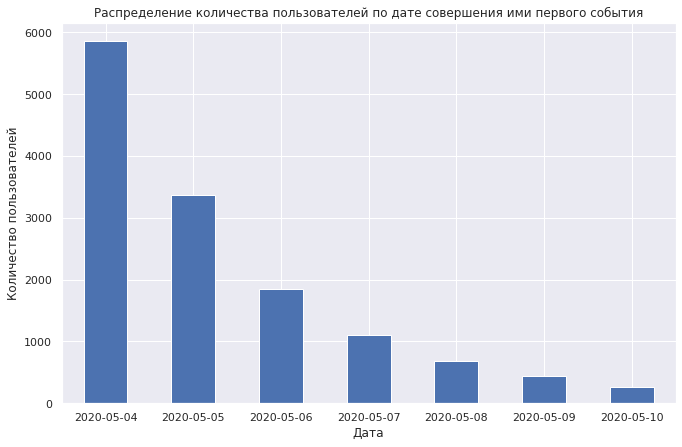

In [8]:
sns.set(rc={'figure.figsize':(11,7)})
first_visits_date = game_actions.groupby(['user_id'])['day'].min().reset_index()
first_visits_date['day'] = first_visits_date['day'].dt.strftime('%Y-%m-%d')
first_visits_date['day'].value_counts().plot(kind='bar', rot=0)
plt.title('Распределение количества пользователей по дате совершения ими первого события')
plt.xlabel('Дата')
plt.ylabel('Количество пользователей')
plt.show()

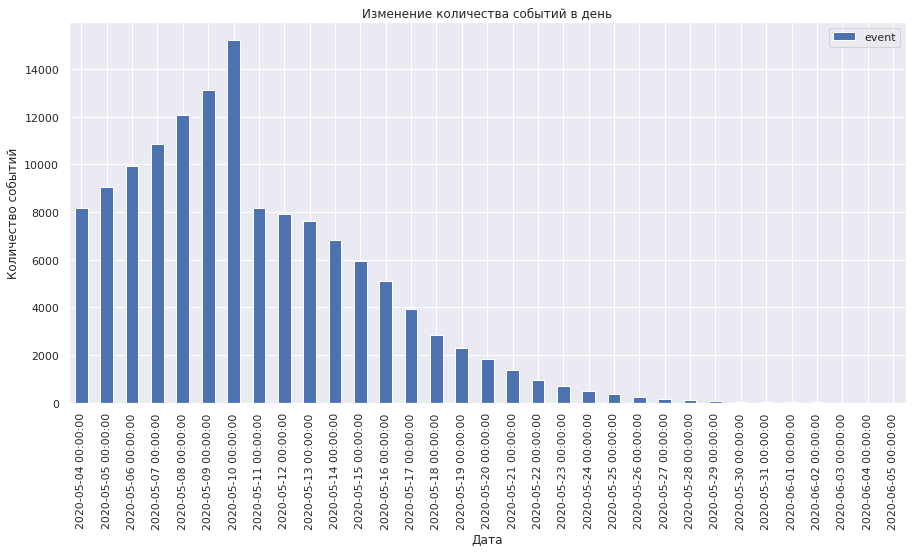

In [9]:
game_actions.groupby('day').agg({'event':'count'}).plot(
    kind='bar', grid=True, title = 'Изменение количества событий в день', figsize = (15,7))
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.show()

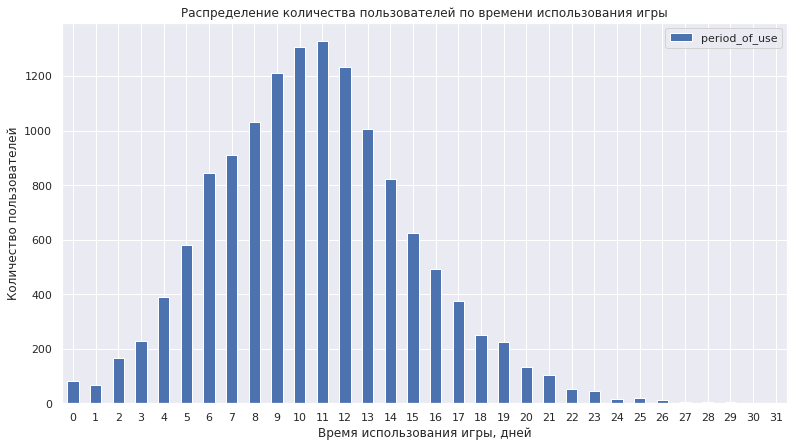

In [10]:
first_visits_date = game_actions.groupby(['user_id'])['day'].min().reset_index()
last_visits_date = game_actions.groupby(['user_id'])['day'].max().reset_index()
period = pd.merge(first_visits_date, last_visits_date, on = 'user_id', suffixes=("_first", "_last"))
period['period_of_use'] = period['day_last'] - period['day_first']
period['period_of_use'] = period['period_of_use'].dt.days
period['period_of_use'].value_counts().reset_index().sort_values(by = 'index').reset_index(drop=True).plot(
    x = 'index', grid=True, title ='Распределение количества пользователей по времени использования игры', rot = 0, kind = 'bar', figsize = (13,7))
plt.xlabel('Время использования игры, дней')
plt.ylabel('Количество пользователей')
plt.show()

#### Вывод

Количество уникальных пользователей игры: 13576  
В датасете представлена информация о событиях в игре в период с 2020-05-04 по 2020-06-05. За это время было построено 127956 зданий, завершен первый уровень 5817 раз, из них 1866 раз через реализацию проекта. При этом здание типа spaceport было простроено 59325 раз, типа assembly_shop - 54494 раза, а research_center - всего 14137 раз.   
Больше всего игроков (5860) стало пользоваться игрой 4 мая, 5 мая пришло уже почти в два раза меньше пользователей, далее с каждым днем количество новых пользователей продолжало снижаться и 10 мая составило 271 человек.  
До 10 мая количество событий в день росло ежедневно, но с прекращением привлечения новых пользователей оно сократилось почти в два раза и в дальнейшем ежедневно снижалось, составив 5 июня всего 5 против 15207 в самый активный день - 10 мая. 

### Анализ расходов на привлечение пользователей. Источники трафика
<a id='2.2'></a>

In [11]:
print('Общая сумма расходов на привлечение за неделю:', round(ad_costs['cost'].sum(),2))

Общая сумма расходов на привлечение за неделю: 7603.58


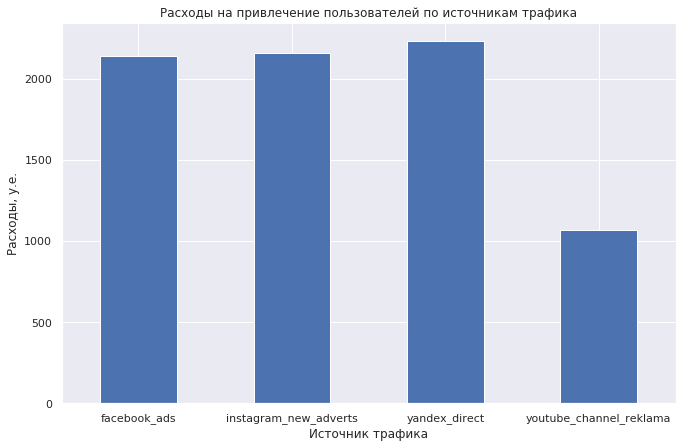

In [12]:
ad_costs.groupby('source')['cost'].sum().plot(kind='bar', rot =0)
plt.title('Расходы на привлечение пользователей по источникам трафика')
plt.xlabel('Источник трафика')
plt.ylabel('Расходы, у.е.')
plt.show()

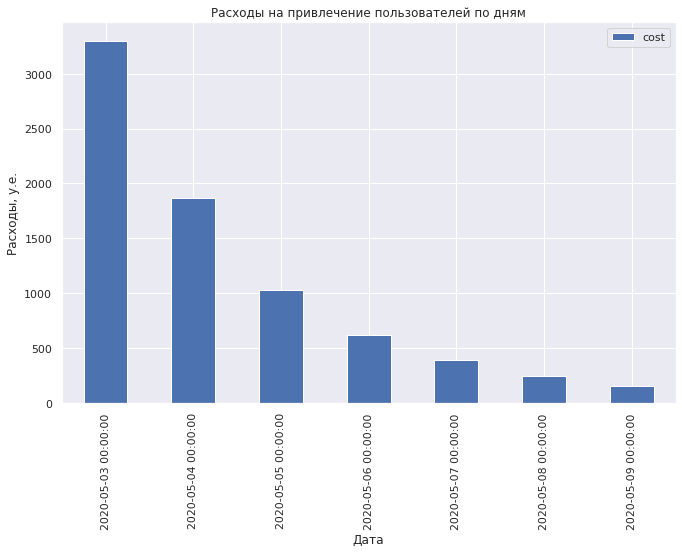

In [13]:
ad_costs.groupby('day').agg({'cost':'sum'}).plot(kind='bar')
plt.title('Расходы на привлечение пользователей по дням')
plt.xlabel('Дата')
plt.ylabel('Расходы, у.е.')
plt.show()

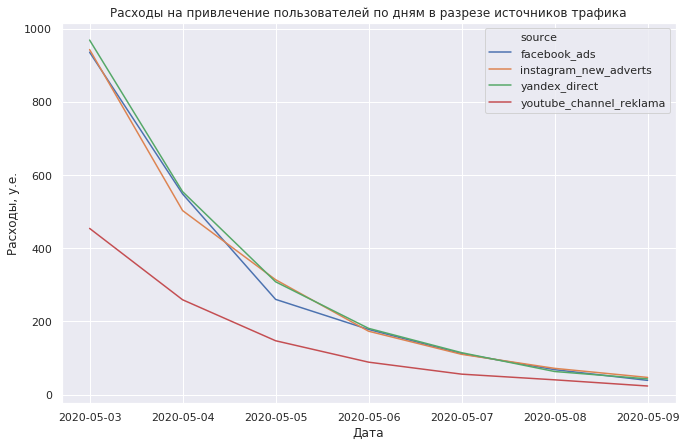

In [14]:
sns.set(rc={'figure.figsize':(11,7)})
sns.lineplot(x='day', y='cost',
             hue='source',
             data=ad_costs)
plt.title('Расходы на привлечение пользователей по дням в разрезе источников трафика')
plt.xlabel('Дата')
plt.ylabel('Расходы, у.е.')
plt.show()

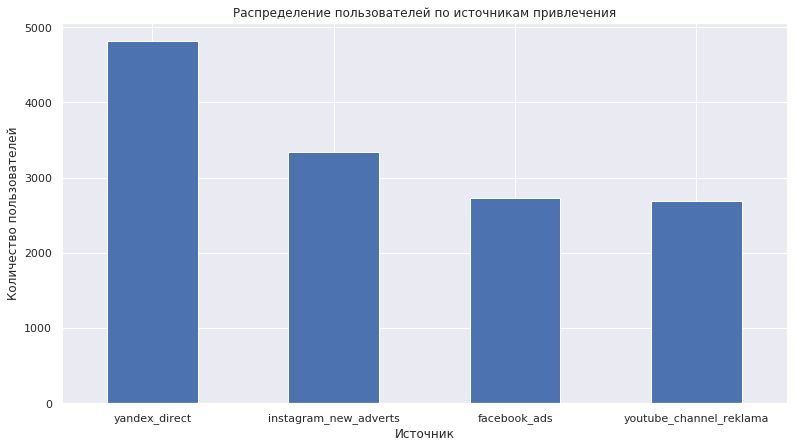

In [15]:
user_source['source'].value_counts().plot(
    grid=True, title ='Распределение пользователей по источникам привлечения', rot = 0, kind = 'bar', figsize = (13,7))
plt.xlabel('Источник')
plt.ylabel('Количество пользователей')
plt.show()

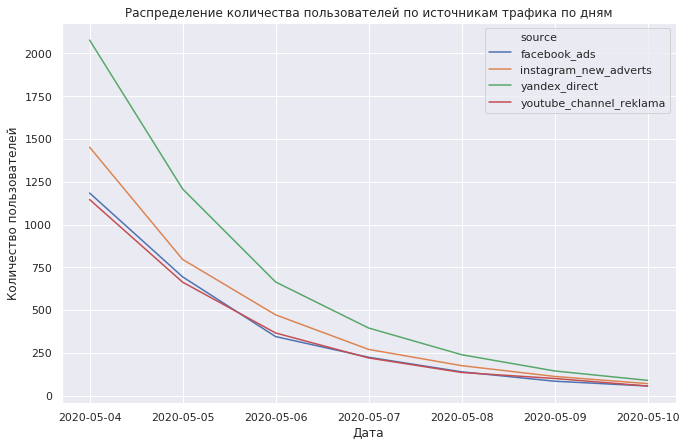

In [16]:
first_visits_date_source = pd.merge(first_visits_date, user_source, on = 'user_id')
sns.set(rc={'figure.figsize':(11,7)})
sns.lineplot(x='day', y='user_id',
             hue='source',
             data=first_visits_date_source.pivot_table(index = ['day', 'source'], values='user_id', aggfunc = 'count').reset_index())
plt.title('Распределение количества пользователей по источникам трафика по дням')
plt.xlabel('Дата')
plt.ylabel('Количество пользователей')
plt.show()

#### Вывод

Всего на привлечение пользователей за неделю было потрачено 7603.58 у.е., из них больше всего на yandex_direct - 2233, чуть меньше на facebook_ads и instagram_new_adverts. Меньше всего на youtube_channel_reklama - 1068.   
Наибольшая сумма была потрачена в первый день, 3 мая, в размере 3302, далее сумма снижалась ежедневно примерно в два раза и на 9 мая составила 151 у.е.  
Больше всего пользователей пришло через yandex_direct, далее с довольно большой разницей, которая уменьшается по мере снижения количества новых пользователей из всех источников, следует instagram_new_adverts. Facebook_ads и youtube_channel_reklama дают примерно одинаковое количество новых пользователей. 

## Анализ влияния событий на совершение целевого события - завершение первого уровня
<a id='3'></a>

In [17]:
finished_stage_1_users = game_actions[game_actions['event'] == 'finished_stage_1']
finished_by_project_users = game_actions[game_actions['project_type'] == 'satellite_orbital_assembly']
finished_stage_1 = game_actions[game_actions['user_id'].isin(finished_stage_1_users['user_id'])]
game_actions[~game_actions['user_id'].isin(finished_by_project_users['user_id'])]
finished_by_project = game_actions[game_actions['user_id'].isin(finished_by_project_users['user_id'])]
finished_by_win = pd.merge(finished_stage_1, finished_by_project, how='outer', indicator=True)
finished_by_win = finished_by_win.query("_merge != 'both'")

In [18]:
print('Всего событий:', game_actions.event.count())
print('Всего событий у пользователей, завершивших уровень:',finished_stage_1.event.count())
print('Всего событий у пользователей, завершивших уровень победой над другим игроком:',finished_by_win.event.count())
print('Всего событий у пользователей, завершивших уровень через реализацию проекта:',finished_by_project.event.count())

Всего событий: 135639
Всего событий у пользователей, завершивших уровень: 68469
Всего событий у пользователей, завершивших уровень победой над другим игроком: 41136
Всего событий у пользователей, завершивших уровень через реализацию проекта: 27333


In [19]:
print('Количество событий пользователей, закончивших уровень:')
finished_stage_1.event.value_counts()

Количество событий пользователей, закончивших уровень:


building            60786
finished_stage_1     5817
project              1866
Name: event, dtype: int64

In [20]:
print('Количество событий пользователей, закончивших уровень через реализацию проекта:')
finished_by_project.event.value_counts()

Количество событий пользователей, закончивших уровень через реализацию проекта:


building            23601
project              1866
finished_stage_1     1866
Name: event, dtype: int64

In [21]:
print('Количество событий пользователей, закончивших уровень победой над другим игроком:')
finished_by_win.event.value_counts()

Количество событий пользователей, закончивших уровень победой над другим игроком:


building            37185
finished_stage_1     3951
Name: event, dtype: int64

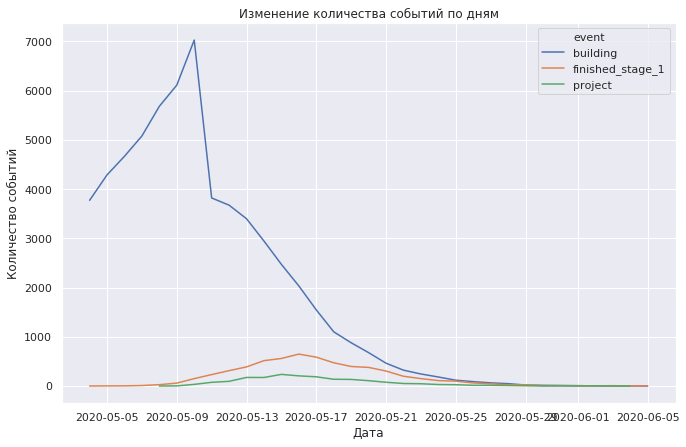

In [22]:
sns.set(rc={'figure.figsize':(11,7)})
sns.lineplot(x='day', y = 'user_id',
             hue='event',
             data=finished_stage_1.groupby(['day','event'])['user_id'].count().reset_index())
plt.title('Изменение количества событий по дням')
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.show()

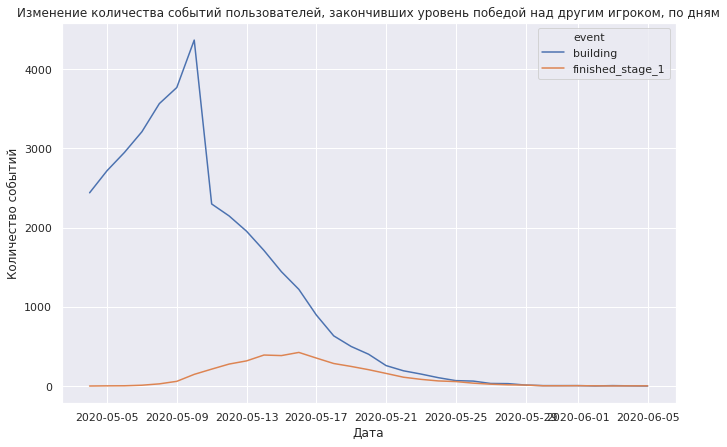

In [23]:
sns.set(rc={'figure.figsize':(11,7)})
sns.lineplot(x='day', y = 'user_id',
             hue='event',
             data=finished_by_win.groupby(['day','event'])['user_id'].count().reset_index())
plt.title('Изменение количества событий пользователей, закончивших уровень победой над другим игроком, по дням')
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.show()

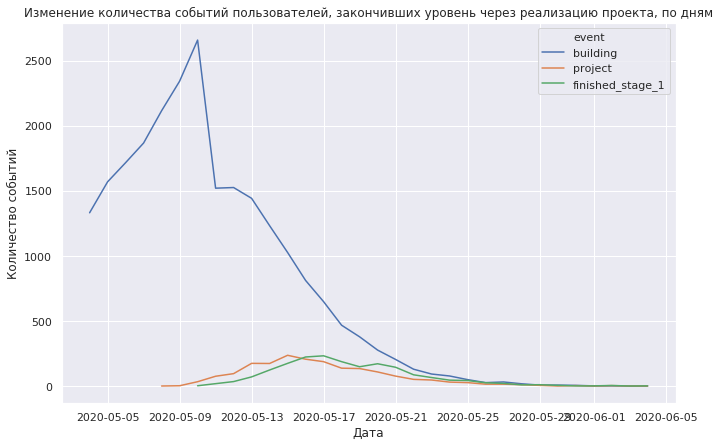

In [24]:
sns.set(rc={'figure.figsize':(11,7)})
sns.lineplot(x='day', y = 'user_id',
             hue='event',
             data=finished_by_project.groupby(['day','event'])['user_id'].count().reset_index())
plt.title('Изменение количества событий пользователей, закончивших уровень через реализацию проекта, по дням')
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.show()

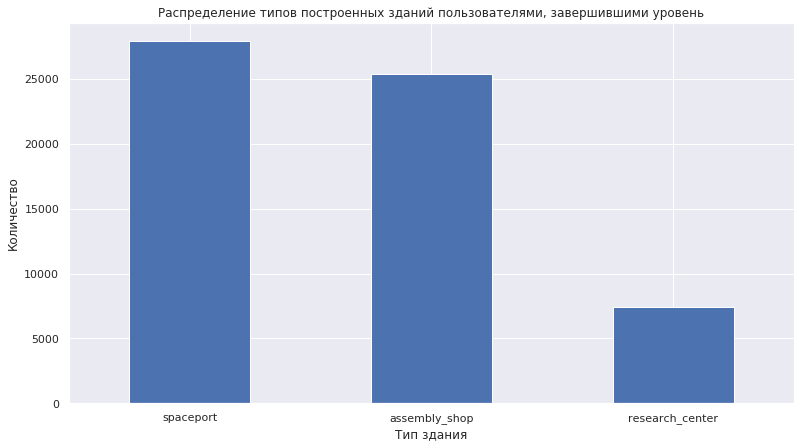

In [25]:
finished_stage_1['building_type'].value_counts().plot(
    grid=True, title ='Распределение типов построенных зданий пользователями, завершившими уровень', rot = 0, kind = 'bar', figsize = (13,7))
plt.xlabel('Тип здания')
plt.ylabel('Количество')
plt.show()

### Вывод

Пользователи, закончившие уровень победой над другим игроком, появились уже с первого дня и наибольшее количество завершений первого уровня приходится на 09-22 мая, тогда как пользователи, закончившие уровень реализацией проекта, появились только с 10 мая и наибольшее количество завершений уровня пришлось на 13-23 мая, при этом, уровень, как правило, завершался чуть позже, чем реализовывался проект.   
Наибольшее количество построенных зданий относится к типу spaceport, чуть меньше к assembly_shop и совсем немного построено зданий типа research_center.

## Анализ модели монетизации
- Расчет затрат на привлечение пользователей;
- Расчет доходов от рекламы;
- Расчет окупаемости модели.

<a id='4'></a>

In [26]:
print('Средний CAC на одного пользователя:', round(ad_costs['cost'].sum() / user_source['user_id'].count(),2))

Средний CAC на одного пользователя: 0.56


In [27]:
ad_costs['first_visits_date'] = ad_costs.day + pd.Timedelta(days=1)
cac = pd.merge(ad_costs.groupby('first_visits_date').agg({'cost':'sum'}), first_visits_date.groupby('day').agg({'user_id':'count'}),
              left_index=True, right_index=True)
cac['cac'] = round((cac['cost'] / cac['user_id']),2)
cac

,cost,user_id,cac
first_visits_date,,,
2020-05-04,3302.451840,5860,0.56
2020-05-05,1865.004649,3361,0.55
2020-05-06,1029.431469,1847,0.56
2020-05-07,620.476519,1109,0.56
2020-05-08,391.852033,688,0.57
2020-05-09,242.767553,440,0.55
2020-05-10,151.592924,271,0.56


In [28]:
cac2 = pd.merge(ad_costs.pivot_table(index = ['first_visits_date', 'source'], values='cost', aggfunc = 'sum').reset_index(), first_visits_date_source.pivot_table(index = ['day', 'source'], values='user_id', aggfunc = 'count').reset_index(),
              left_index=True, right_index=True)
cac2['cac'] = round((cac2['cost'] / cac2['user_id']),2)

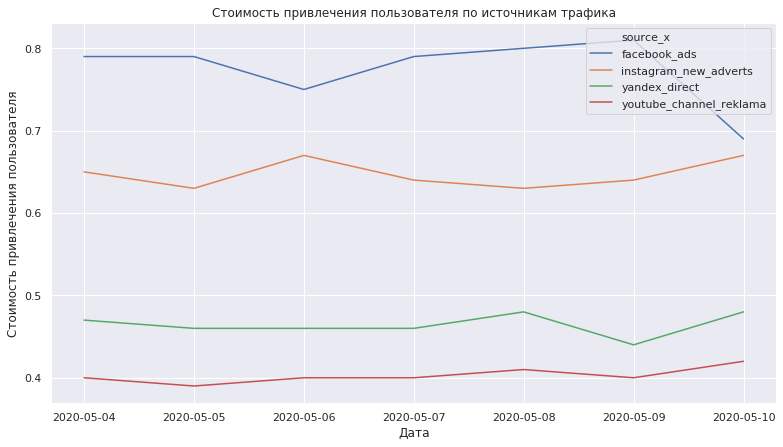

In [29]:
sns.set(rc={'figure.figsize':(13,7)})
sns.lineplot(x='first_visits_date', y='cac',
             hue='source_x',
             data=cac2)
plt.title('Стоимость привлечения пользователя по источникам трафика')
plt.xlabel('Дата')
plt.ylabel('Стоимость привлечения пользователя')
plt.show()

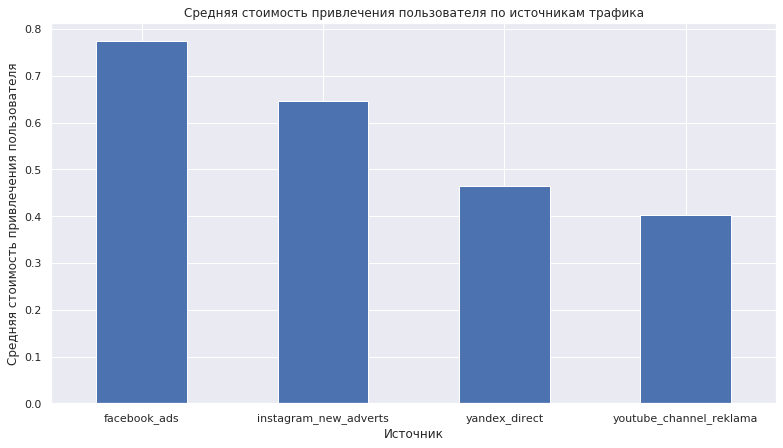

In [30]:
cac2.groupby('source_x')['cac'].mean().plot(
    grid=True, title ='Средняя стоимость привлечения пользователя по источникам трафика', rot = 0, kind = 'bar', figsize = (13,7))
plt.xlabel('Источник')
plt.ylabel('Средняя стоимость привлечения пользователя')
plt.show()

Рассчитаем возможную выручку в случае показа рекламы на экране с выбором типа объекта для постройки. Пусть стоимость одного показа - 7 центов.

In [31]:
game_actions_user_source = pd.merge(game_actions, user_source, on = 'user_id')
game_actions_user_source.loc[game_actions_user_source['event'] == 'building', 'revenue'] = 0.07

game_actions_user_source.head(30)
print('Общая сумма выручки от показа рекламы на экране с выбором типа объекта для постройки за месяц:', round(game_actions_user_source['revenue'].sum(),2))

Общая сумма выручки от показа рекламы на экране с выбором типа объекта для постройки за месяц: 8956.92


In [32]:
print('Средняя выручка на одного пользователя:', round(game_actions_user_source.groupby('user_id')['revenue'].sum().mean(),2))

Средняя выручка на одного пользователя: 0.66


In [33]:
game_actions_youtube = game_actions_user_source.query('source == "youtube_channel_reklama"')
game_actions_facebook = game_actions_user_source.query('source == "facebook_ads"')
game_actions_instagram = game_actions_user_source.query('source == "instagram_new_adverts"')
game_actions_yandex = game_actions_user_source.query('source == "yandex_direct"')

In [34]:
print('Сумма выручки от показа рекламы на экране с выбором типа объекта для постройки по источникам привлечения пользователей:')
print(game_actions_user_source.groupby('source')['revenue'].sum())

Сумма выручки от показа рекламы на экране с выбором типа объекта для постройки по источникам привлечения пользователей:
source
facebook_ads               1829.17
instagram_new_adverts      2227.05
yandex_direct              3152.24
youtube_channel_reklama    1748.46
Name: revenue, dtype: float64


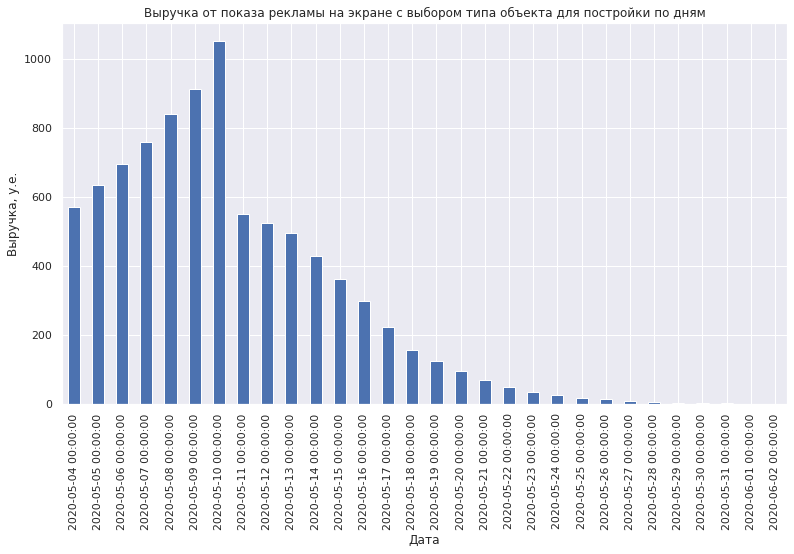

In [35]:
game_actions_user_source.groupby(['day'])['revenue'].sum().head(30).plot(
    grid=True, title ='Выручка от показа рекламы на экране с выбором типа объекта для постройки​ по дням', kind = 'bar', figsize = (13,7))
plt.xlabel('Дата')
plt.ylabel('Выручка, у.е.')
plt.show()

Ежедневное распределение выручки ведет себя так же, как и распределение количества событий в день - т.е. резко падает с 11 мая и далее уменьшается почти до нуля 5 июня.  
Наибольшую выручку принесли бы пользователи, пришедшие через yandex_direct - 3152 у.е., через instagram_new_adverts - 2227 у.е., через facebook_ads - 1829 и через youtube_channel_reklama - 1748 у.е.

In [36]:
rev = game_actions_user_source.pivot_table(index = ['day', 'source'], values='revenue', aggfunc = 'sum').reset_index()

In [37]:
income = pd.merge(ad_costs.groupby('source')['cost'].sum().reset_index(), rev.groupby('source')['revenue'].sum().reset_index(), on = 'source')
income['income'] = income['revenue'] - income['cost']
print('Доход при планируемой модели монетизации:', round(income['income'].sum(),2))
income

Доход при планируемой модели монетизации: 1353.34


,source,cost,revenue,income
0,facebook_ads,2140.904643,1829.17,-311.734643
1,instagram_new_adverts,2161.441691,2227.05,65.608309
2,yandex_direct,2233.111449,3152.24,919.128551
3,youtube_channel_reklama,1068.119204,1748.46,680.340796


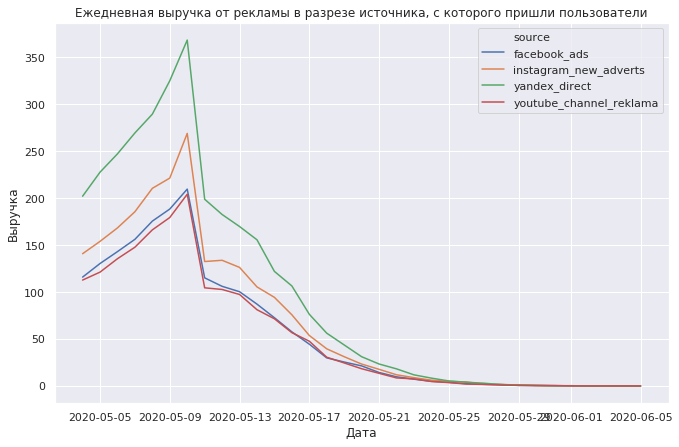

In [38]:
sns.set(rc={'figure.figsize':(11,7)})
sns.lineplot(x='day', y='revenue',
             hue='source',
             data=rev)
plt.title('Ежедневная выручка от рекламы в разрезе источника, с которого пришли пользователи')
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.show()

In [39]:
game_actions_user_source2 = pd.merge(game_actions_user_source, first_visits_date, on = 'user_id', suffixes=("", "_first"))
game_actions_user_source2 = pd.merge(game_actions_user_source2, cac2.drop(['source_y', 'day'], axis=1), left_on=['day_first', 'source'], right_on=['first_visits_date', 'source_x'])

In [40]:
report = game_actions_user_source2.groupby(['source', 'day_first', 'day']).agg(
    {'revenue':'sum', 'cac':'mean', 'user_id_y':'mean'}).reset_index()
report 

,source,day_first,day,revenue,cac,user_id_y
0,facebook_ads,2020-05-04,2020-05-04,115.99,0.79,1184
1,facebook_ads,2020-05-04,2020-05-05,61.11,0.79,1184
2,facebook_ads,2020-05-04,2020-05-06,69.37,0.79,1184
3,facebook_ads,2020-05-04,2020-05-07,72.24,0.79,1184
4,facebook_ads,2020-05-04,2020-05-08,83.16,0.79,1184
...,...,...,...,...,...,...
711,youtube_channel_reklama,2020-05-10,2020-05-26,0.14,0.42,56
712,youtube_channel_reklama,2020-05-10,2020-05-27,0.00,0.42,56
713,youtube_channel_reklama,2020-05-10,2020-05-29,0.07,0.42,56
714,youtube_channel_reklama,2020-05-10,2020-05-30,0.07,0.42,56


In [41]:
report['ltv'] = report['revenue'] / report['user_id_y']
report['romi'] = report['ltv'] / report['cac']
report['age'] = report['day'] - report['day_first']
report.groupby('source')['revenue'].sum()

source
facebook_ads               1829.17
instagram_new_adverts      2227.05
yandex_direct              3152.24
youtube_channel_reklama    1748.46
Name: revenue, dtype: float64

In [42]:
output = report.pivot_table(
    index='day_first', columns='age', values='romi', aggfunc='mean'
)
output.cumsum(axis=1).round(2).fillna('')

age,0 days,1 days,2 days,3 days,4 days,5 days,6 days,7 days,8 days,9 days,10 days,11 days,12 days,13 days,14 days,15 days,16 days,17 days,18 days,19 days,20 days,21 days,22 days,23 days,24 days,25 days,26 days,27 days,28 days,29 days,30 days,31 days
day_first,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-05-04,0.18,0.28,0.38,0.49,0.62,0.75,0.91,0.99,1.06,1.13,1.18,1.22,1.26,1.28,1.30,1.31,1.32,1.33,1.34,1.34,1.34,1.34,1.34,1.34,1.34,1.34,1.34,1.34,1.34,1.34,1.34,1.34
2020-05-05,0.19,0.29,0.40,0.52,0.66,0.81,0.89,0.97,1.04,1.10,1.15,1.19,1.22,1.24,1.26,1.27,1.28,1.28,1.29,1.29,1.29,1.29,1.29,1.29,1.29,1.29,1.29,1.29,1.29,,,
2020-05-06,0.18,0.28,0.39,0.51,0.66,0.73,0.81,0.88,0.94,0.99,1.04,1.08,1.10,1.12,1.13,1.14,1.15,1.15,1.15,1.16,1.16,1.16,1.16,1.16,1.16,1.16,1.16,1.16,1.16,1.16,1.16,
2020-05-07,0.18,0.28,0.39,0.51,0.57,0.64,0.72,0.78,0.83,0.88,0.91,0.94,0.97,0.99,1.00,1.01,1.02,1.02,1.03,1.03,1.04,1.04,1.04,1.04,1.04,1.04,1.04,1.04,1.04,1.04,,
2020-05-08,0.17,0.26,0.36,0.42,0.47,0.54,0.62,0.68,0.72,0.77,0.80,0.83,0.85,0.87,0.88,0.89,0.89,0.90,0.90,0.90,0.91,0.91,0.91,0.91,0.91,,0.91,0.91,,,,
2020-05-09,0.17,0.26,0.31,0.37,0.44,0.50,0.57,0.63,0.68,0.71,0.74,0.77,0.79,0.81,0.82,0.83,0.84,0.85,0.85,0.86,0.86,0.86,0.86,0.86,0.86,0.86,,,,,,
2020-05-10,0.17,0.20,0.25,0.30,0.35,0.42,0.49,0.54,0.57,0.61,0.64,0.67,0.69,0.71,0.73,0.74,0.74,0.75,0.76,0.76,0.76,0.76,0.76,0.76,,,,,,,,


При рассматриваемой модели монетизации пользователи, пришедшие в первые 4 дня, окупаются на 8-14 день

In [43]:
report['age'] = report['age'].dt.days
report['day_first'] = report['day_first'].dt.strftime('%Y-%m-%d')

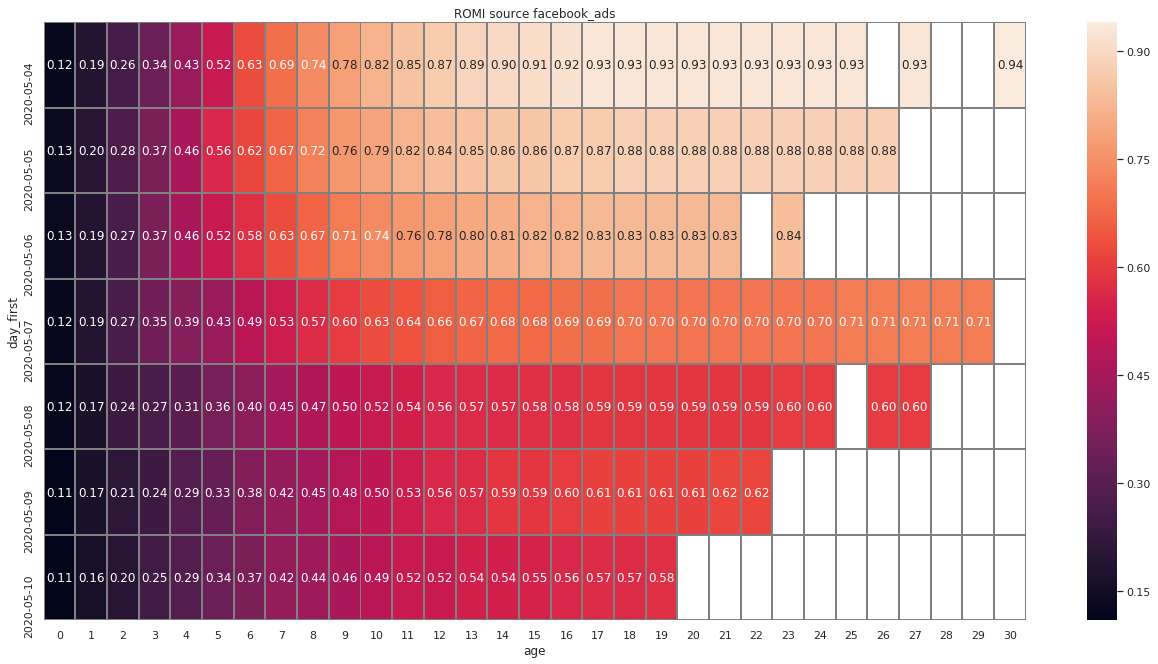

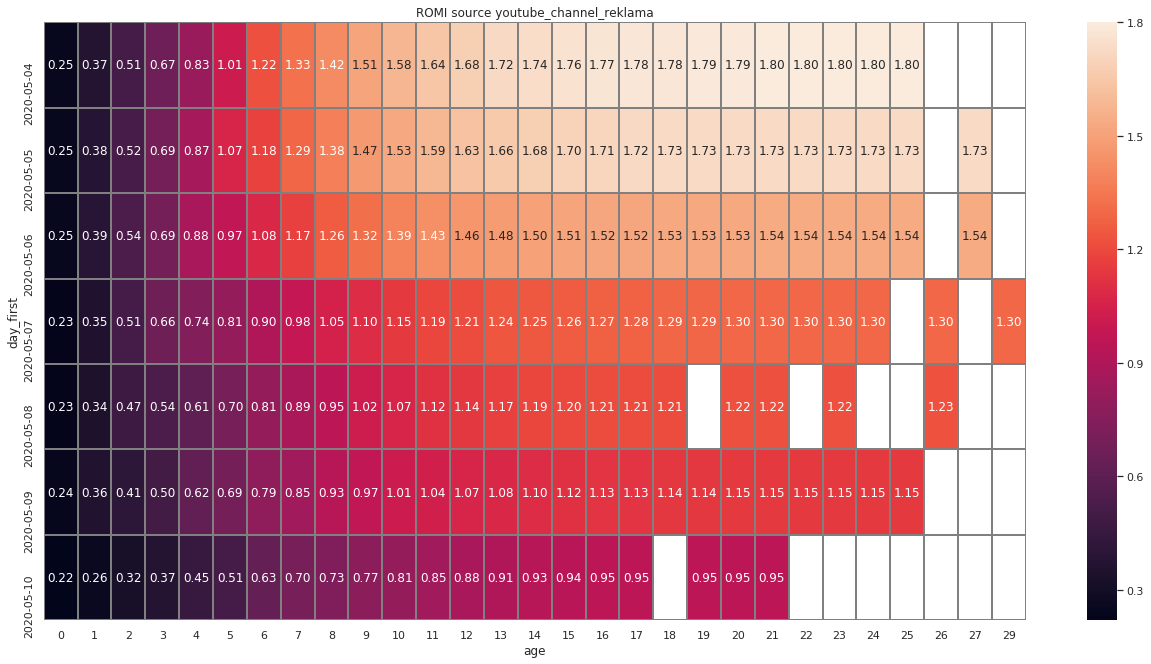

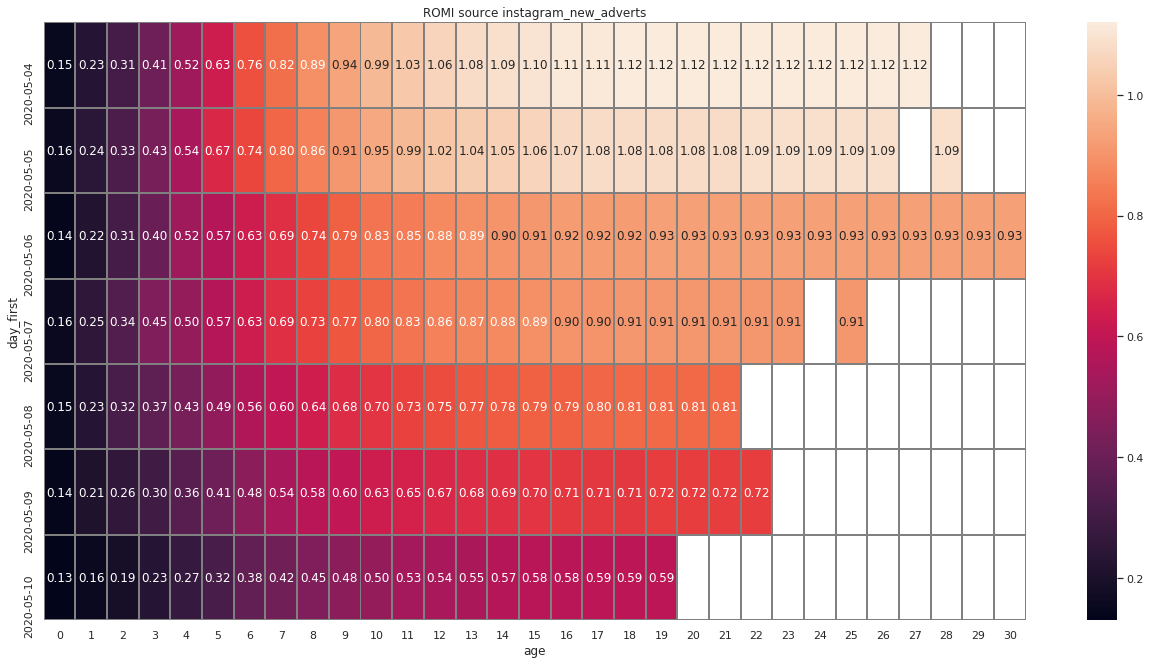

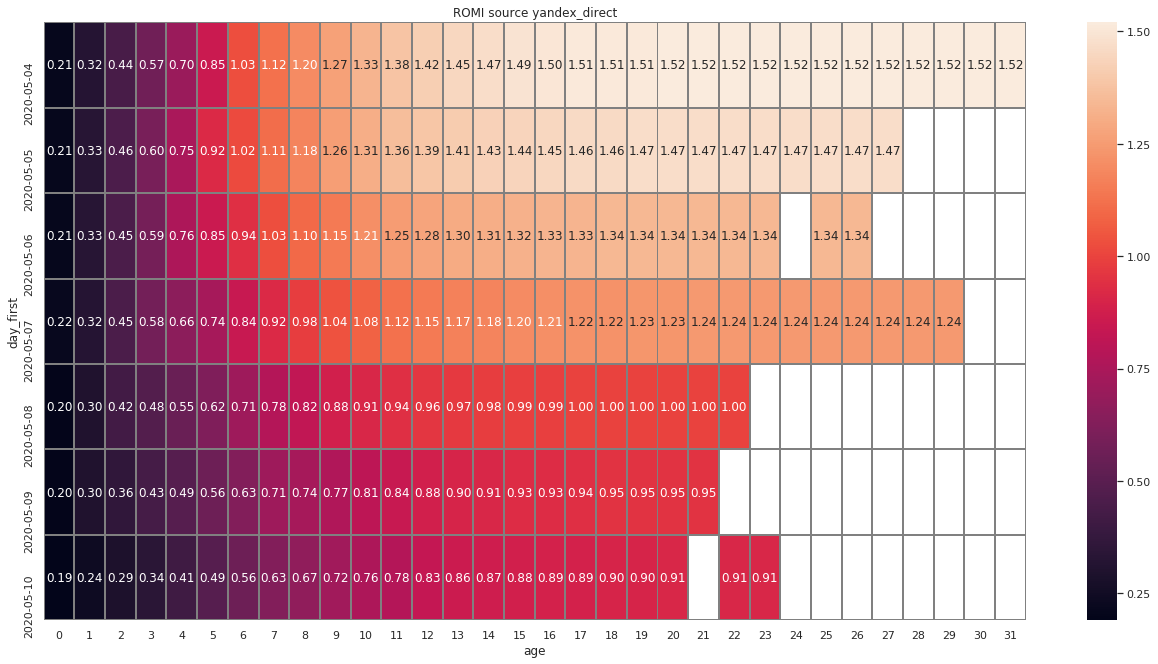

In [44]:
def romi(n):
    sns.set(style='white')
    plt.figure(figsize=(22, 11))
    plt.title('ROMI source {}'.format(n))
    sns.heatmap(report[report['source'] == n].pivot_table(
        index='day_first', columns='age', values='romi', aggfunc='mean'
    ).cumsum(axis=1).round(2), annot=True, fmt='.2f', linewidths=1, linecolor='gray')
    plt.show()
    
list = ['facebook_ads', 'youtube_channel_reklama', 'instagram_new_adverts', 'yandex_direct']
for i in list:
    romi(i)     

In [45]:
print('Выручка:', (game_actions['event'].value_counts()[0] - 13576)*0.07) 
print('Доход:', round((game_actions['event'].value_counts()[0] - 13576)*0.07-ad_costs['cost'].sum(),2)) 

Выручка: 8006.6
Доход: 403.02


Если не включать рекламу сразу с выбора первого объекта для постройки, то доход может составить 403.02 у.е. Рентабельность при таком варианте получается всего около 5%, но при этом увеличивается вероятность того, что игра затянет большее количество пользователей. 

### Вывод

В среднем привлечение одного пользователя обошлось в 0.56 у.е.   
Самая высокая стоимость привлечения через facebook_ads - почти 0.8, далее instagram_new_adverts - примерно 0.65, yandex_direct - чуть выше 0.45 и самая низкая стоимость привлечения через youtube_channel_reklama - около 0.4.  
   Общая сумма выручки от показа рекламы в течение месяца на экране с выбором типа объекта для постройки составила бы 8956.92 у.е. при стоимости одного показа 7 центов. При таком размере выручки на одного пользователя приходится в среднем 0.66 у.е. выручки, что больше стоимости привлечения одного пользователя на 10 центов или на 17.9%.  
   Ежедневное распределение выручки ведет себя так же, как и распределение количества событий в день - т.е. резко падает с 11 мая и далее уменьшается почти до нуля 5 июня.  
   Ожидаемо наибольшее количество выручки принесли бы пользователи, пришедшие через yandex_direct (3152 у.е.) и instagram_new_adverts (2227 у.е.).   
   Доход при данной модели монетизации составил бы 1353.34 у.е., при этом наибольший доход (919 у.е.) принесли бы пользователи, привлеченные с помощью yandex_direct, а затраты на привлечение пользователей через facebook_ads не окупились бы вообще.   
   Пользователи, пришедшие через yandex_direct, начинают окупаться в среднем на 6-9 день, через youtube_channel_reklama - на 5-10 день. На 12 день окупились пользователи, привлеченные через instagram_new_adverts только в первые два дня.   
   В целом, при рассматриваемой модели монетизации пользователи, пришедшие в первые 4 дня, окупаются на 8-14 день.   
   При этом показ рекламы при каждом выборе типа объекта для постройки может быть излишне навязчивым, т.к. на этот тип событий приходится 94% от общего числа событий.  
   Для увеличения вовлеченности пользователей в игру до начала показа рекламы, можно начать включать ее с выбора второго объекта для постройки. При текущих расходах на привлечение это позволит получить доход в 403.02 у.е.  
   Также стоить обратить внимание на то, что стоимость привлечения одного пользователя через facebook_ads обходится заметно дороже остальных источников. При перераспределении бюджета на более дешевые источники (yandex_direct и youtube_channel_reklama) возможно увеличить получаемый доход или компенсировать ту часть, которая будет потеряна из-за вероятного оттока пользователей вследствие рекламы. 

## Проверка статистических гипотез
<a id='5'></a>

### Проверка гипотезы о равенстве времени прохождения уровня между пользователями, которые заканчивают уровень через реализацию проекта, и пользователями, которые заканчивают уровень победой над другим игроком
<a id='5.1'></a>

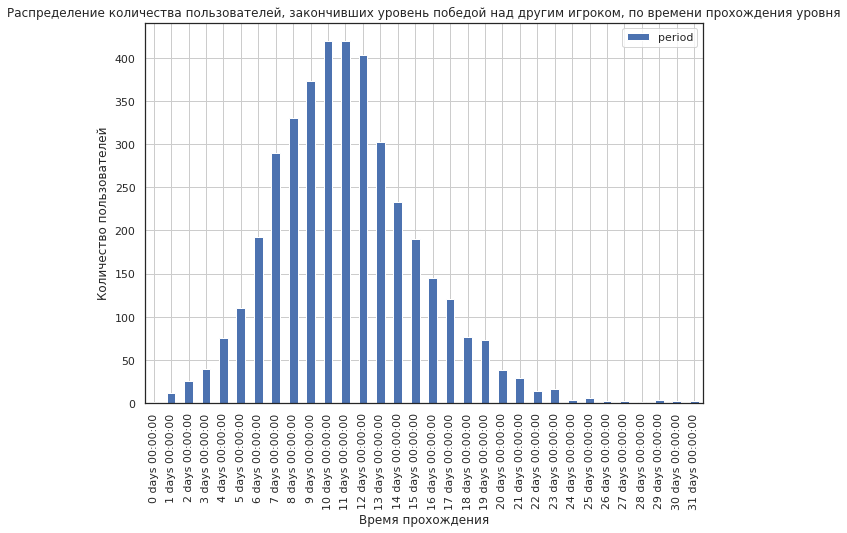

In [46]:
first_event_by_win = finished_by_win.groupby(['user_id'])['day'].min().reset_index()
last_event_by_win = finished_by_win.groupby(['user_id'])['day'].max().reset_index()
period_by_win = pd.merge(first_event_by_win, last_event_by_win, on = 'user_id', suffixes=("_first", "_last"))
period_by_win['period'] = period_by_win['day_last'] - period_by_win['day_first']
period_by_win['period'].value_counts().reset_index().sort_values(by = 'index').reset_index(drop=True).plot(
    x = 'index', grid=True, title ='Распределение количества пользователей, закончивших уровень победой над другим игроком, по времени прохождения уровня', rot = 90, kind = 'bar', figsize = (10,7))
plt.xlabel('Время прохождения')
plt.ylabel('Количество пользователей')
plt.show()

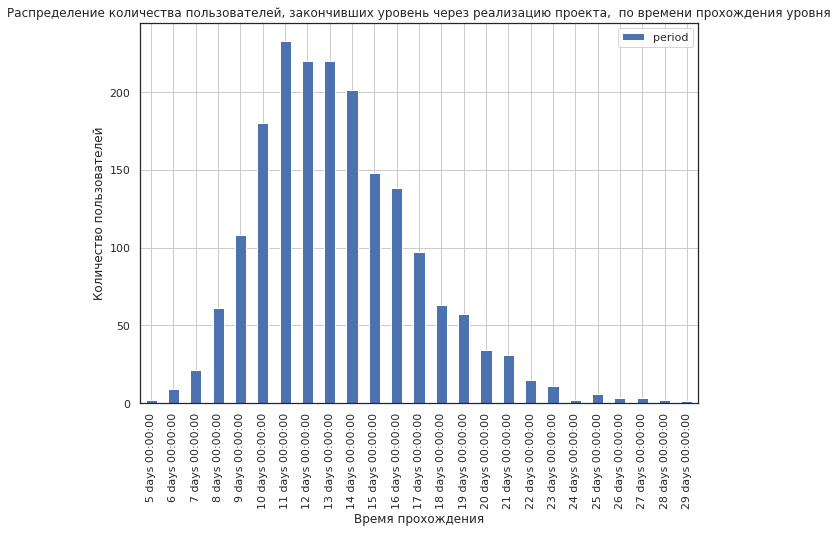

In [47]:
first_event_by_project = finished_by_project.groupby(['user_id'])['day'].min().reset_index()
last_event_by_project = finished_by_project.groupby(['user_id'])['day'].max().reset_index()
period_by_project = pd.merge(first_event_by_project, last_event_by_project, on = 'user_id', suffixes=("_first", "_last"))
period_by_project['period'] = period_by_project['day_last'] - period_by_project['day_first']
period_by_project['period'].value_counts().reset_index().sort_values(by = 'index').reset_index(drop=True).plot(
    x = 'index', grid=True, title ='Распределение количества пользователей, закончивших уровень через реализацию проекта,  по времени прохождения уровня', rot = 90, kind = 'bar', figsize = (10,7))
plt.xlabel('Время прохождения')
plt.ylabel('Количество пользователей')
plt.show()

Проверим статистические гипотезы Н0 и Н1.  
Н0: Отсутствует статистически значимое различие между средним временем прохождения уровня пользователями, которые заканчивают уровень через реализацию проекта, и пользователями, которые заканчивают уровень победой над другим игроком.    
Н1: Среднее время прохождения уровня пользователями двух групп имеет статистически значимое различие.    
Критический уровень статистической значимости зададим значением 0.05.

In [48]:
period_by_project['period'].dt.days.mean()

13.396570203644158

In [49]:
period_by_win['period'].dt.days.mean()

11.0584662110858

In [50]:
alpha = 0.05  

results = st.ttest_ind(period_by_project['period'].dt.days.values, period_by_win['period'].dt.days.values, equal_var = False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 6.570466755643636e-105
Отвергаем нулевую гипотезу


#### Вывод

Время прохождения уровня между пользователями, которые заканчивают уровень через реализацию проекта, и пользователями, которые заканчивают уровень победой над другим игроком различается и полученное значение p-value говорит о том, что такое различие между временем прохождения уровня не случайно.

### Проверка гипотезы о равенстве долей пользователей, закончивших уровень, в зависимости от источника трафика
<a id='5.2'></a>

In [51]:
game_actions_user_source = pd.merge(game_actions, user_source, on = 'user_id')
game_actions_user_source.groupby('source')['user_id'].count()

source
facebook_ads               27672
instagram_new_adverts      33757
yandex_direct              47694
youtube_channel_reklama    26516
Name: user_id, dtype: int64

In [52]:
game_actions_youtube = game_actions_user_source.query('source == "youtube_channel_reklama"')
game_actions_facebook = game_actions_user_source.query('source == "facebook_ads"')
game_actions_instagram = game_actions_user_source.query('source == "instagram_new_adverts"')
game_actions_yandex = game_actions_user_source.query('source == "yandex_direct"')

In [53]:
print('Процент пользователей, закончивших уровень:')
print('Среди всех пользователей:', 
       game_actions[game_actions['event']=='finished_stage_1']['user_id'].nunique()/game_actions['user_id'].nunique()*100)
print('Среди пользователей, пришедших через youtube_channel_reklama:', 
       game_actions_youtube[game_actions_youtube['event']=='finished_stage_1']['user_id'].nunique()/game_actions_youtube['user_id'].nunique()*100)
print('Среди пользователей, пришедших через instagram_new_adverts:', 
       game_actions_instagram[game_actions_instagram['event']=='finished_stage_1']['user_id'].nunique()/game_actions_instagram['user_id'].nunique()*100)
print('Среди пользователей, пришедших через facebook_ads:', 
       game_actions_facebook[game_actions_facebook['event']=='finished_stage_1']['user_id'].nunique()/game_actions_facebook['user_id'].nunique()*100)
print('Среди пользователей, пришедших через yandex_direct:', 
       game_actions_yandex[game_actions_yandex['event']=='finished_stage_1']['user_id'].nunique()/game_actions_yandex['user_id'].nunique()*100)

Процент пользователей, закончивших уровень:
Среди всех пользователей: 42.847672362993514
Среди пользователей, пришедших через youtube_channel_reklama: 43.14966492926284
Среди пользователей, пришедших через instagram_new_adverts: 43.80041828503137
Среди пользователей, пришедших через facebook_ads: 42.18635363169479
Среди пользователей, пришедших через yandex_direct: 42.391529997924025


Проверим статистические гипотезы Н0 и Н1.  
Н0: Отсутствует статистически значимое различие между долями пользователей, закончившими уровень, в группе всех пользователей и пользователей, пришедших из разных источников трафика.   
Н1: Доли пользователей, закончивших уровень, имеют ститистически значимое различие.   
Критический уровень статистической значимости зададим значением 0.05.

In [54]:
def test (t1, t2, s1, s2):
    trials_1 = t1
    successes_1 = s1
 
    trials_2 = t2
    successes_2 = s2
    
    alpha = .05 
    p1 = successes_1/trials_1
    p2 = successes_2/trials_2
    p_combined = (successes_1 + successes_2)/(trials_1 + trials_2)
    difference = p1 - p2
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials_1 + 1/trials_2))
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
 
    print('p-значение:',p_value)
 
    if p_value < alpha:
        print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
    else:
        print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.")
        

In [55]:
print('Все пользователи и пользователи из youtube_channel_reklama')
test(game_actions_youtube['user_id'].nunique(), 
     game_actions['user_id'].nunique(), 
     game_actions_youtube[game_actions_youtube['event']=='finished_stage_1']['user_id'].nunique(), 
     game_actions[game_actions['event']=='finished_stage_1']['user_id'].nunique())

Все пользователи и пользователи из youtube_channel_reklama
p-значение: 0.7726288683731881
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.


In [56]:
print('Все пользователи и пользователи из instagram_new_adverts')
test(game_actions_instagram['user_id'].nunique(), 
     game_actions['user_id'].nunique(), 
     game_actions_instagram[game_actions_instagram['event']=='finished_stage_1']['user_id'].nunique(), 
     game_actions[game_actions['event']=='finished_stage_1']['user_id'].nunique())

Все пользователи и пользователи из instagram_new_adverts
p-значение: 0.31871913940157603
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.


In [57]:
print('Все пользователи и пользователи из facebook_ads')
test(game_actions_facebook['user_id'].nunique(), 
     game_actions['user_id'].nunique(), 
     game_actions_facebook[game_actions_facebook['event']=='finished_stage_1']['user_id'].nunique(), 
     game_actions[game_actions['event']=='finished_stage_1']['user_id'].nunique())

Все пользователи и пользователи из facebook_ads
p-значение: 0.5241624756781942
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.


In [58]:
print('Все пользователи и пользователи из yandex_direct')
test(game_actions_yandex['user_id'].nunique(), 
     game_actions['user_id'].nunique(), 
     game_actions_yandex[game_actions_yandex['event']=='finished_stage_1']['user_id'].nunique(), 
     game_actions[game_actions['event']=='finished_stage_1']['user_id'].nunique())

Все пользователи и пользователи из yandex_direct
p-значение: 0.5824427540505401
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.


Проверим статистические гипотезы Н0 и Н1.
Н0: Отсутствует статистически значимое различие между долями пользователей, закончившими уровень, в группах пользователей, пришедших из разных источников трафика.
Н1: Доли пользователей, закончивших уровень, имеют ститистически значимое различие.
Критический уровень статистической значимости зададим значением 0.05.

In [59]:
print('Пользователи из yandex_direct и facebook_ads')
test(game_actions_yandex['user_id'].nunique(), 
     game_actions_facebook['user_id'].nunique(), 
     game_actions_yandex[game_actions_yandex['event']=='finished_stage_1']['user_id'].nunique(), 
     game_actions_facebook[game_actions_facebook['event']=='finished_stage_1']['user_id'].nunique())

Пользователи из yandex_direct и facebook_ads
p-значение: 0.8624388026512437
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.


In [60]:
print('Пользователи из yandex_direct и instagram_new_adverts')
test(game_actions_yandex['user_id'].nunique(), 
     game_actions_instagram['user_id'].nunique(), 
     game_actions_yandex[game_actions_yandex['event']=='finished_stage_1']['user_id'].nunique(), 
     game_actions_instagram[game_actions_instagram['event']=='finished_stage_1']['user_id'].nunique())

Пользователи из yandex_direct и instagram_new_adverts
p-значение: 0.20595754565724533
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.


In [61]:
print('Пользователи из yandex_direct и youtube_channel_reklama')
test(game_actions_yandex['user_id'].nunique(), 
     game_actions_youtube['user_id'].nunique(), 
     game_actions_yandex[game_actions_yandex['event']=='finished_stage_1']['user_id'].nunique(), 
     game_actions_youtube[game_actions_youtube['event']=='finished_stage_1']['user_id'].nunique())

Пользователи из yandex_direct и youtube_channel_reklama
p-значение: 0.5244230207169549
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.


In [62]:
print('Пользователи из facebook_ads и youtube_channel_reklama')
test(game_actions_facebook['user_id'].nunique(), 
     game_actions_youtube['user_id'].nunique(), 
     game_actions_facebook[game_actions_facebook['event']=='finished_stage_1']['user_id'].nunique(), 
     game_actions_youtube[game_actions_youtube['event']=='finished_stage_1']['user_id'].nunique())

Пользователи из facebook_ads и youtube_channel_reklama
p-значение: 0.4737412931629539
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.


In [63]:
print('Пользователи из facebook_ads и instagram_new_adverts')
test(game_actions_facebook['user_id'].nunique(), 
     game_actions_instagram['user_id'].nunique(), 
     game_actions_facebook[game_actions_facebook['event']=='finished_stage_1']['user_id'].nunique(), 
     game_actions_instagram[game_actions_instagram['event']=='finished_stage_1']['user_id'].nunique())

Пользователи из facebook_ads и instagram_new_adverts
p-значение: 0.20644137086490777
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.


In [64]:
print('Пользователи из youtube_channel_reklama и instagram_new_adverts')
test(game_actions_youtube['user_id'].nunique(), 
     game_actions_instagram['user_id'].nunique(), 
     game_actions_youtube[game_actions_youtube['event']=='finished_stage_1']['user_id'].nunique(), 
     game_actions_instagram[game_actions_instagram['event']=='finished_stage_1']['user_id'].nunique())

Пользователи из youtube_channel_reklama и instagram_new_adverts
p-значение: 0.6123664865502236
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.


#### Вывод

Таким образом, во всех рассмотренных группах пользователей (все пользователи; группы пользователей в зависимости от источника их трафика) доля тех, кто закончил первый уровень, не различается.

## Итоговые выводы
<a id='6'></a>

Входные данные не имеют пропусков, практически не содержат дубликатов и требуют только минимальной обработки.   
Датасеты содержат информацию о событиях в игре в период с 2020-05-04 по 2020-06-05 для 13576 уникальных пользователей, а также информацию об источниках и стоимости их привлечения.  
Доля пользователей, завершивших уровень, примерно одинакова для всех пользователей из разных источников трафика и составляет в среднем 42.85%   
Пользователи, которые заканчивают уровень через реализацию проекта, в среднем тратят на прохождение уровня 13.4 дня.   
Пользователи, которые заканчивают уровень победой над другим игроком, в среднем тратят на прохождение уровня 11.06 дня.   
На привлечение пользователей за неделю было потрачено 7603.58 у.е., в среднем привлечение одного пользователя обошлось в 0.56 у.е.
Общая сумма выручки от показа рекламы в течение месяца на экране с выбором типа объекта для постройки составила бы 8956.92 у.е. при стоимости одного показа 7 центов. При таком размере выручки на одного пользователя приходится в среднем 0.66 у.е. выручки, что больше стоимости привлечения одного пользователя на 10 центов или на 17.9%. Доход при данной модели монетизации составил бы 1353.34 у.е., при этом наибольший доход (919 у.е.) принесли бы пользователи, привлеченные с помощью yandex_direct, а затраты на привлечение пользователей через facebook_ads не окупились бы вообще. В среднем стоимость привлечения через facebook_ads почти 0.8. Учитывая, что пользователи из разных источников с одинаковой частотой переходят на следующий уровень, целесообразно перенаправить бюджет на привлечение новых пользователей на другие источники с меньшей стоимостью привлечения пользователя - yandex_direct и youtube_channel_reklama (или новый источник, но в этом случае есть вероятность, что он обойдется дороже/пользователи будут завершать уровень реже).  
При этом показ рекламы при каждом выборе типа объекта для постройки может быть излишне навязчивым, т.к. на этот тип событий приходится 94% от общего числа событий.  
Для снижения рекламной нагрузки и увеличения возможности вовлечь пользователя в игру до начала показа рекламы, можно начать включать ее не сразу, а с выбора второго объекта для постройки. При этом сохраняется возможность получить доход в размере 403 у.е.